**Introducing BESS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [3]:
os.chdir('/home/MA')

In [4]:
power_balance = pd.read_pickle('Calculations/Spain/power_balance_Spain.pkl')

Define battery size

In [5]:
battery_size = 72

In [6]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [7]:
eta_discharge = 0.85

Define function for battery dispatch

In [8]:
from Battery_dispatch_function import BatteryDispatch

In [9]:
power_balance = BatteryDispatch(power_balance, battery_size, eta_discharge, max_c_charge, max_c_discharge)

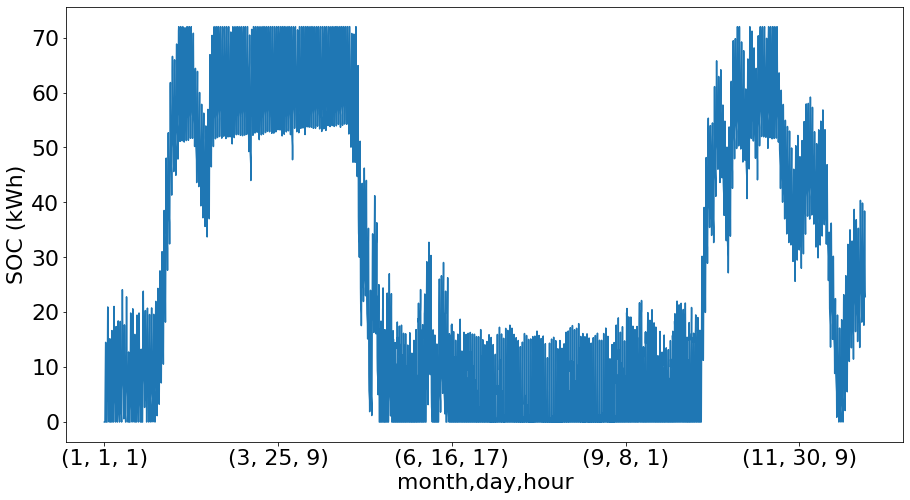

In [10]:
power_balance['SoC'].plot(ylabel = 'SOC (kWh)'); 

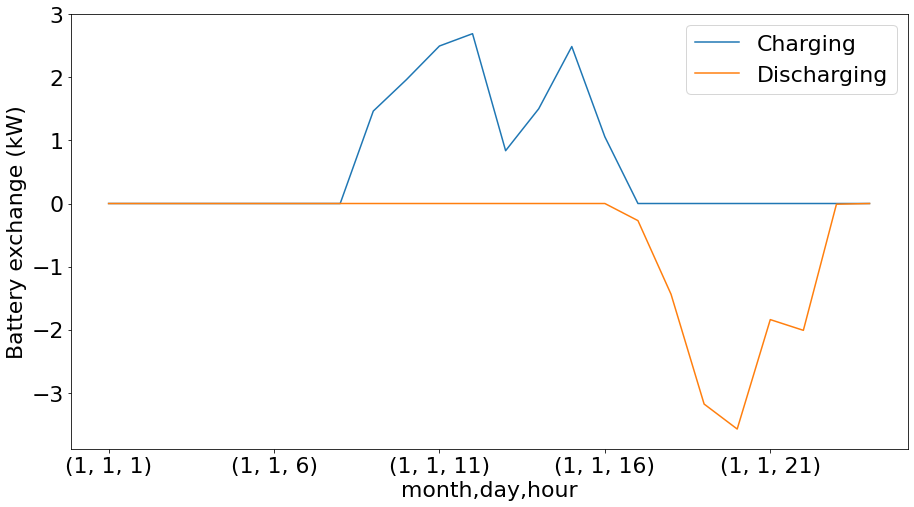

In [11]:
power_balance[['Charging', 'Discharging']].head(24).plot(ylabel = 'Battery exchange (kW)'); 

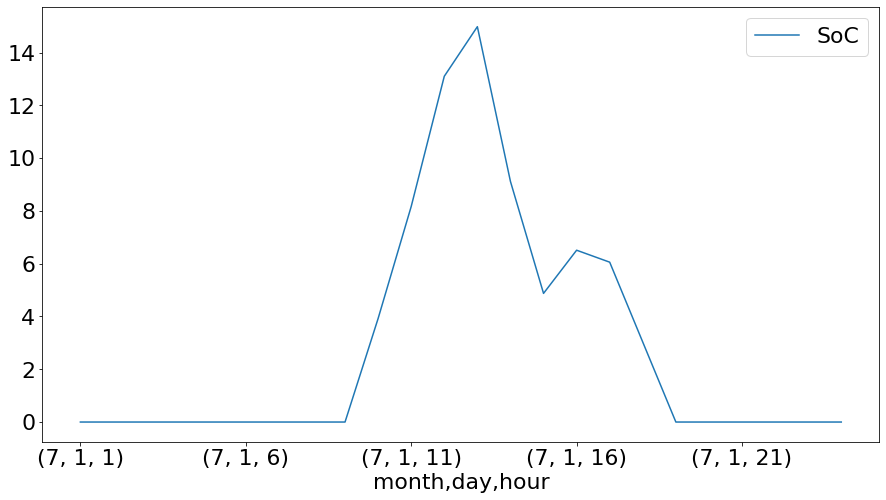

In [12]:
power_balance[['SoC']].iloc[power_balance.index.get_level_values('month') == 7].head(24).plot();

In [13]:
sum(power_balance['Charging'])

7155.9581041215115

In [14]:
sum(power_balance['Discharging'])

-6063.166839010332

Check how many cycles were carried out

In [15]:
sum(power_balance['Charging'])/battery_size

99.38830700168766

In [16]:
power_balance['exchange grid new'] = power_balance['to Grid New'] - power_balance['from Grid New']

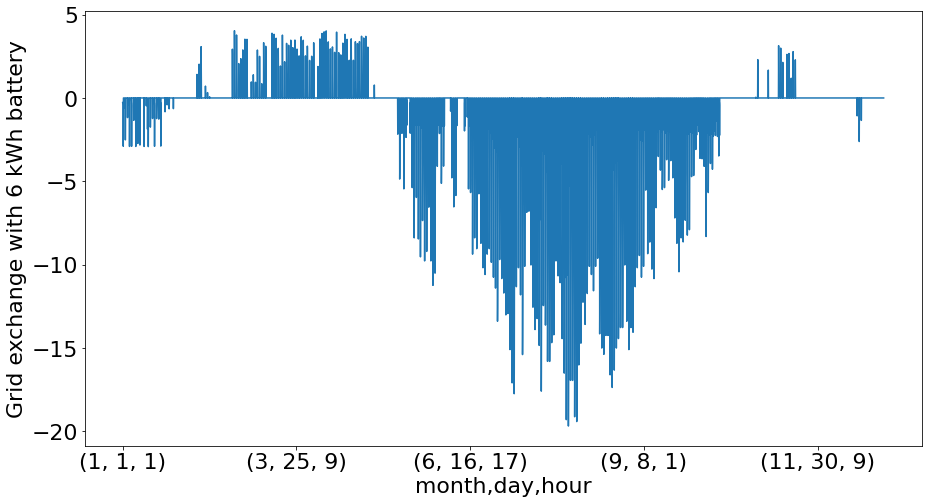

In [17]:
power_balance['exchange grid new'].plot(ylabel = 'Grid exchange with 6 kWh battery');

Self-consumption share with BESS

In [18]:
sum(power_balance['consumption'] - power_balance['from Grid New'])/sum(power_balance['from PV'])

0.8756885905181715

Curtailment calculation with BESS

In [19]:
sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

0.04198379874955043

PV share with BESS

In [20]:
1-sum(power_balance['from Grid New'])/sum(power_balance['consumption'])

0.6499731526911572

Losses in the battery system

In [21]:
(sum(power_balance['Charging']) + sum(power_balance['Discharging']))/sum(power_balance['from PV'])

0.08232761073228764

Reduced consumption from grid:
also mention PV reduction, check with curtailment!

In [22]:
grid_savings = sum(power_balance['Discharging'])
grid_savings

-6063.166839010332

**CO$_2$ calculations**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [24]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

In [25]:
os.chdir('/home/MA')

In [26]:
PV_lifetime = 25 #years

In [27]:
power_balance = pd.read_pickle('Calculations/Spain/power_balance_Spain.pkl')

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [28]:
battery_lifetime = 15 # years

Electricity mix carbon intensity for Spain

Ember AG-Energiebilanzen (Daniel's Excel sheet)

In [29]:
grid_emissions_Spain = 228 # g CO2/kWh

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [30]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [31]:
CO2_intensity_China = 637

In [32]:
electricity_PV_production = 1597 # kWh_el kWp-1

In [33]:
PV_size = 6 #kW_p

### CO2 savings of PV only

Yearly energy self consumed, therefore reduced consumption from grid

In [34]:
self_consumption_kWh = sum(power_balance['consumption'] - power_balance['from Grid'])

In [35]:
total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China

In [36]:
reduced_CO2_PV_g = grid_emissions_Spain * self_consumption_kWh * PV_lifetime - total_CO2_PV_prod

In [37]:
reduced_CO2_PV_t = reduced_CO2_PV_g/1000000

In [38]:
reduced_CO2_PV_t

25.590847634019024

### CO2 savings of added batteries

In [39]:
battery_size = [0, 6, 12, 18, 24, 72]
results = pd.DataFrame()
results['battery_size'] = battery_size
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [40]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
    results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

In [41]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [42]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_Spain / 1000000

For a PV lifetime of 25 years, this corresponds to a gross saving of 

In [43]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance, and for a replacement after 15 years (battery lifetime)

In [44]:
results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)

Net saving of battery deployment

In [45]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [46]:
results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 

In [47]:
results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']

In [48]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored
0,0,0.581092,-0,-0,-0,-0,0.0,0.000000,-0,0
1,6,0.403644,2002.09,50052.1,0.456475,11.4119,1432.5,0.912502,10.4994,0.177448
2,12,0.245724,3783.84,94596,0.862715,21.5679,2865.0,1.825005,19.7429,0.335368
3,18,0.103605,5385.28,134632,1.22784,30.6961,4297.5,2.737507,27.9586,0.477487
4,24,0.0580986,5895.26,147382,1.34412,33.603,5730.0,3.650010,29.953,0.522994
5,72,0.0419838,6063.17,151579,1.3824,34.5601,17190.0,10.950030,23.61,0.539108


In [49]:
results.set_index("battery_size",drop=True,inplace=True)

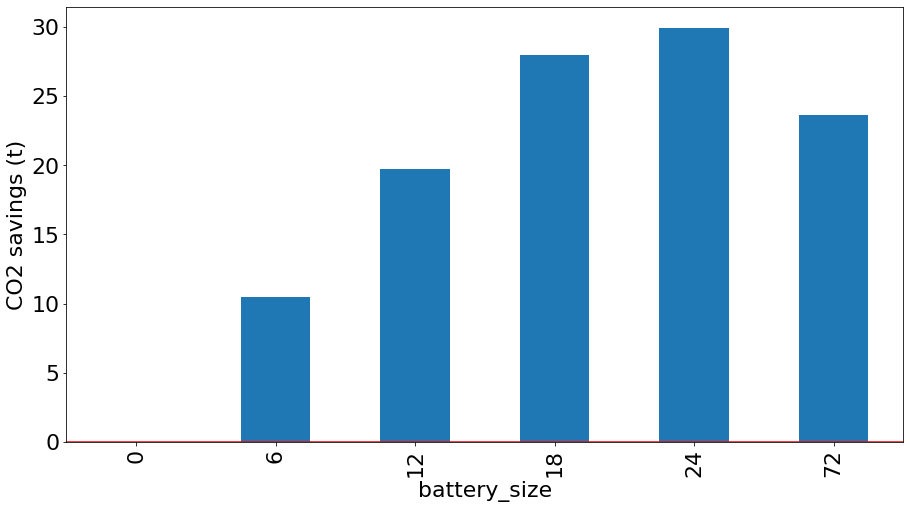

In [50]:
results['net_CO2_savings'].plot.bar(ylabel ='CO2 savings (t)');
plt.axhline(y=0, color='r', linestyle='-')

In [51]:
results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t

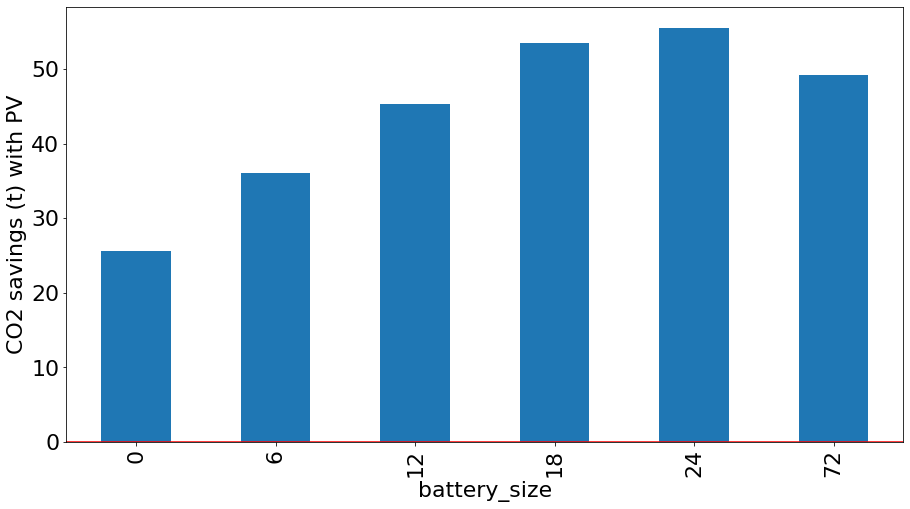

In [52]:
results['net_CO2_savings_with_PV'].plot.bar(ylabel ='CO2 savings (t) with PV');
plt.axhline(y=0, color='r', linestyle='-')

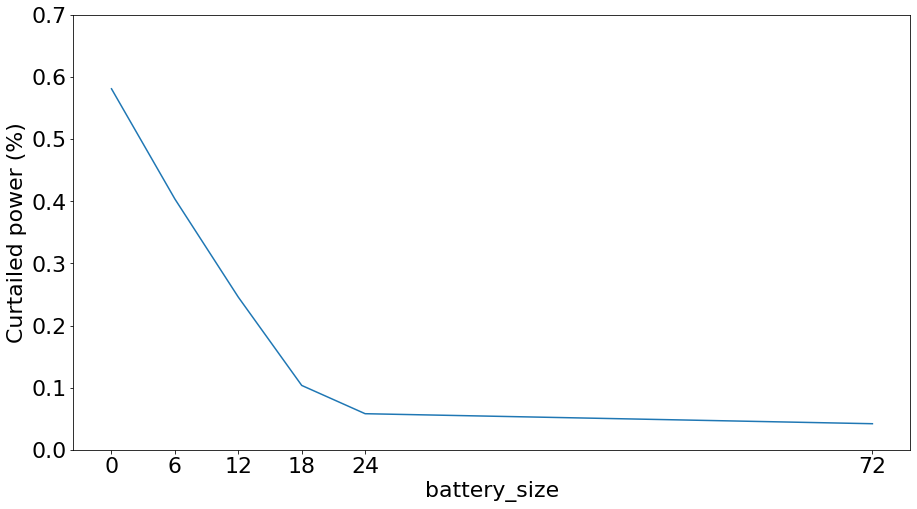

In [53]:
results['curtailment'].plot(xticks = battery_size, ylabel = 'Curtailed power (%)', ylim = ([0, 0.7]));

## EROI calculations

Electricity intensity used for PV production

In [54]:
PV_production_hourly = pd.read_pickle('Calculations/Spain/PV_production_Spain.pkl')

In [55]:
yearly_PV_production = sum(PV_production_hourly)

In [56]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [57]:
results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [58]:
results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']

**Firstly, calculate the EROI for the case where electricity can be made usful through the distribution grid:**

In [59]:
results['EROI_grid_useful'] = results['EROI_gen']

**Now, let's consider the case where power is curtailed unless stored for later use**

In [60]:
results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])

In [61]:
results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [62]:
results['ESOI'] = results['ESOI'].fillna(0)

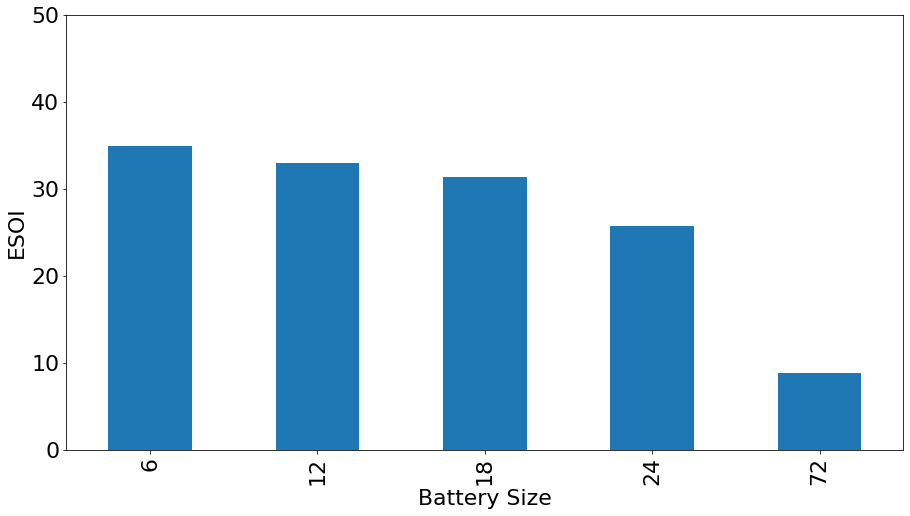

In [63]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI', ylim = ([0, 50]));

In [64]:
results

,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored,net_CO2_savings_with_PV,total_elec_PV_prod,ESOI,EROI_gen,EROI_grid_useful,EROI_grid_curtailed
battery_size,,,,,,,,,,,,,,,
0,0.581092,-0,-0,-0,-0,0.0,0.000000,-0,0,25.5908,9582,0.000000,34.631838,34.631838,14.507548
6,0.403644,2002.09,50052.1,0.456475,11.4119,1432.5,0.912502,10.4994,0.177448,36.0902,9582,34.940402,34.631838,34.631838,17.096272
12,0.245724,3783.84,94596,0.862715,21.5679,2865.0,1.825005,19.7429,0.335368,45.3337,9582,33.017786,34.631838,34.631838,18.352259
18,0.103605,5385.28,134632,1.22784,30.6961,4297.5,2.737507,27.9586,0.477487,53.5494,9582,31.327984,34.631838,34.631838,18.863425
24,0.0580986,5895.26,147382,1.34412,33.603,5730.0,3.650010,29.953,0.522994,55.5438,9582,25.721033,34.631838,34.631838,17.639447
72,0.0419838,6063.17,151579,1.3824,34.5601,17190.0,10.950030,23.61,0.539108,49.2009,9582,8.817869,34.631838,34.631838,9.782384


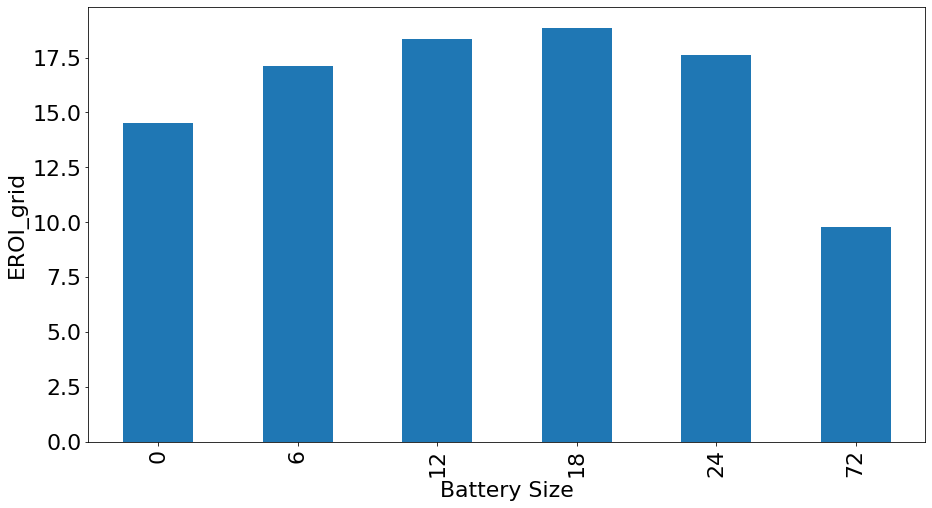

In [65]:
results['EROI_grid_curtailed'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');